## Petfinder Pawpularity Score Prediction
This notebook implements a deep regression model for the competition [Petfinder.my - Pawpularity Contest](https://www.kaggle.com/c/petfinder-pawpularity-score/overview). The problem basically consists of assigning a popularity score to images of pets up for adoption. The given data includes images of pets and their corresponding popularity scores from 0-100. We need design a model that predicts this score. Also given optinally are some binary metadata features about the pets in the images like: blur, occlusion, eye visibility etc. We currently do not use these optional features for our baseline model


The next cells perform basic imports. We use [timm](https://github.com/rwightman/pytorch-image-models) to get our pre-trained backbone feature extractors and add some custom layers after that to obtain deep regression results.

A novel method was developed to obtain an end-to-end deep regression model that converts score values to probability distributions and performs training using these prob. distribution labels, in order to get more gradient information backpropogated as compared to backpropogating just one output value. Helper functions that convert these scores to distributions and vice-versa are also defined in the next cells.


In [2]:
import os, shutil, pandas as pd , numpy as np, cv2
import torch,time
import torch.utils.data as data
import cv2
import os,sys
from glob import glob
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
import math
import torch.optim as optim
#sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

#details of implementation of distribution output. See next cell

prob_bin = 0.8
ranger = [1,100] #range of regression, both included
k=5 #divide the regression range into bins of this length 
#in this example - [(-4,0),(1-5),(6,10),..,(96-100),(101,105)] . first and last bin are just there to handle edge cases, they should never be predict.

rem = ((ranger[1]-ranger[0])+1 )%k
if rem != 0:
    ranger[1] += (k-rem)
lister = [0 for i in range(int(ranger[1]/k)+2)]

output_dist_length = len(lister)  #length of output distribution 22 in this case


The current device is cuda:0


The next cell contains functions to convert the score to distributions and vice-versa. We basically divide the range of regression('ranger' defined above) into bins of equal width('k' defined above). We then assign a high probability value('prob_bin' above) to the bin containing the actual score, and the remaining probability is divided among the two adjacent bins based on their distance from the score(i.e more the distance of an adjacent bin from the score, lesser the probability) to allow for better learning and regularization.

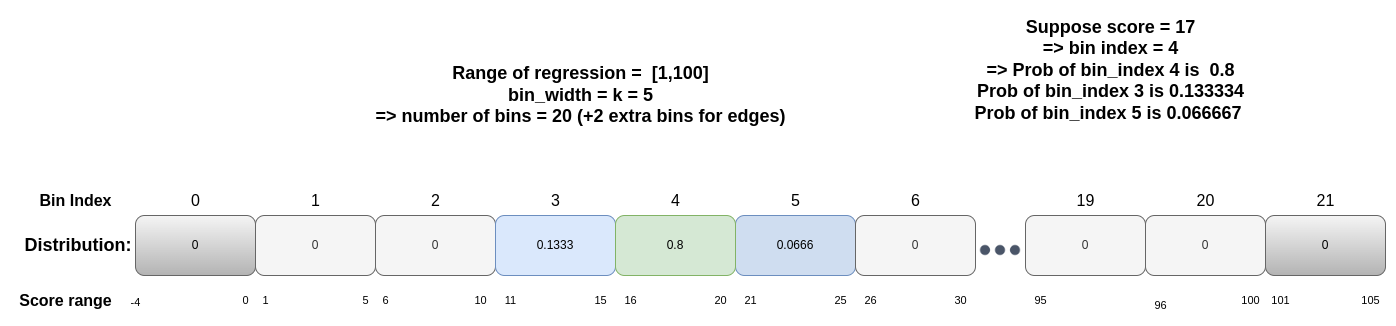

As we can see from the figure, the bin containing the score:17 i.e bin_index 4 has the highest probability : 0.8. Since 17 is closer to the upper limit of bin_index 3 : 15 as compared to the lower limit of bin_index 5 : 21, the remaining probability is divided based on the inverse ratio of distances from these lower and upper limits of these adjoining bins. The score_to_dist function does this calculation.

The dist_to_score funcion does the opposite job of this function but in a slightly different way. It first picks the bin index with the highest probability as the bin containing the score. Next, to determine the exact position/score in the selected bin, we compare the sum of all probabilities of all previous bins to sum of probs. of all bins to the right and get distance ratio as an inverse function of the prob ratio as in the previous function. This is done to take into consideration that the network may not give exact 0 outputs for non-adjoining bins and we do not wnat to loose this information. This is essentially the same as the prev function, jsut that we ignore the non-adjacent bins since we have assigned them a zero value.

In [ ]:
def score_to_dist(score): #given a score, return a prob dist of bins of width k (+2)
    dist = [0 for i in range(output_dist_length)]
    bin_index = int((score-ranger[0])/k) + 1  #find index of bin of score. careful that the 0th and -1th index are not to be used for this
    dist[bin_index] = prob_bin
    rem_prob = 1-prob_bin
    upper_limit_prev_bin = (ranger[0] + ((bin_index -1)*k)) -1 #lower limit of current_bin - 1
    distance_from_prev_bin = score-upper_limit_prev_bin
    prob_ratio_prev_bin = ((k+1)-distance_from_prev_bin)/(k+1)
    prob_prev_bin = rem_prob*prob_ratio_prev_bin
    prob_next_bin = rem_prob - prob_prev_bin
    dist[bin_index - 1] = prob_prev_bin
    dist[bin_index + 1] = prob_next_bin
    #print(dist)
    return dist



def dist_to_score(dist):   #given a distribution(list of prob dist), return score in range of regression
    
    dist_list_batch = dist.tolist() #dist.cpu().detach().numpy()
    return_list=[]
    for dist_list in dist_list_batch:
    
        bin_index = dist_list.index(max(dist_list))
        #print("highest_index ",bin_index)
        prev_prob_sum =0
        next_prob_sum =0
        for i in range(bin_index):
            prev_prob_sum += dist_list[i]
        #print("sum upto prev bin:",prev_prob_sum)
        next_prob_sum = 1 - (prev_prob_sum + dist_list[bin_index])
        #print("sum from next bin:",next_prob_sum,dist_list[bin_index])
        prev_prob_ratio = prev_prob_sum/(prev_prob_sum+next_prob_sum)
        prev_bin_ul = ranger[0] + (k*(bin_index-1)) -1 #upper limit of previous bin
        distance_from_prev_bin = round((1-prev_prob_ratio)*(k+1)) #can get rid of round()
        score = prev_bin_ul + distance_from_prev_bin
        return_list.append(score)
    #print(score)
    return return_list

#print(score_to_dist(17))

 

This cell defines the data pre-processing pipeline using albumentations and also defines the data loader functions for test, val and train datasets.


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


backbone = 'swin_base_patch4_window12_384'# 'resnet50' 
if backbone == 'swin_base_patch4_window12_384':
    input_dim = 384
else:
    input_dim = 224


transform = A.Compose([
        A.LongestMaxSize(max_size=input_dim, interpolation=1),
        A.PadIfNeeded(min_height=input_dim, min_width=input_dim, border_mode=0, value=(1,1,1)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
])



class TrainDataset(data.Dataset):
    def __init__(self, root='.'):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'train','*.jpg'))
        self.train_df = pd.read_csv("train.csv")
        #print(self.img_files)
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            image_id = os.path.basename(img_path).split('.')[0]
            row = self.train_df.loc[self.train_df['Id'] == image_id]
            img=cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #print('a, ',img.shape)
            data_t =  transform(image=img)['image']
            #print(data_t.shape,type(data_t))
            score = row.to_dict(orient='list')['Pawpularity'][0]
            return (data_t, torch.Tensor(score_to_dist(score)))

    def __len__(self):
        return len(self.img_files)
    
    
class ValDataset(data.Dataset):
    def __init__(self, root='.'):
        super(ValDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'val','*.jpg'))
        self.train_df = pd.read_csv("train.csv")
        #print(self.img_files)
            

    def __getitem__(self, index):
            #global transform
            img_path = self.img_files[index]
            image_id = os.path.basename(img_path).split('.')[0]
            row = self.train_df.loc[self.train_df['Id'] == image_id]
            img=cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data_t =  transform(image=img)['image']
            #score = row.to_dict(orient='list')['Pawpularity'][0]
            return (data_t, row.to_dict(orient='list'))

    def __len__(self):
        return len(self.img_files)


class TestDataset(data.Dataset):
    def __init__(self, root='.'): #/kaggle/input/petfinder-pawpularity-score
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'test','*.jpg'))
        self.train_df = pd.read_csv("test.csv")
        #print(self.img_files)
            

    def __getitem__(self, index):
            #global transform
            img_path = self.img_files[index]
            image_id = os.path.basename(img_path).split('.')[0]
            row = self.train_df.loc[self.train_df['Id'] == image_id]
            img=cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data_t =  transform(image=img)['image']
            #score = row.to_dict(orient='list')['Pawpularity'][0]
            return (data_t, row.to_dict(orient='list'))

    def __len__(self):
        return len(self.img_files)

import matplotlib.pyplot as plt
def plot_losses(epoch_train_losses, epoch_val_losses=[]): 
  plt.plot(epoch_train_losses, 'b-',label='Taining Losses')
  plt.plot(epoch_val_losses, color='orange',label='Validation Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.legend()
  plt.show()
    


This cell defines our custom network. The network has a pretrained backbone of either swin or resnet50 (from timm) that we use as a feature extractor. We then add some fc layers with activations and regularizations/poolings to get a final output of size equal to the lenght of the probability distribution we defined above ('output_dist_length'). This is then run through a softmax layer to get the final probability distribution which can be compared to our generated label distribution. The definition of the network and the forward pass vary according to the backbone chosen but the final output layer given the same output probability distribution.

In [4]:
class CustomBackbone(nn.Module):
    
    def __init__(self):
        super(CustomBackbone, self).__init__()
        self.header = timm.create_model(backbone, pretrained=True,num_classes=518)  
        self.BN = nn.BatchNorm2d(2048)
        self.adpt = nn.AdaptiveAvgPool2d((1,1))
        if backbone == 'swin_base_patch4_window12_384':
            self.classifier_layer = nn.Sequential(
                nn.Linear(1024, 518),
                #nn.BatchNorm1d(800),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(518, 256),
                nn.ReLU(),
                nn.Linear(256, output_dist_length),
                nn.Softmax()

            )
        else:
            self.classifier_layer = nn.Sequential(
                nn.Linear(2048, 1024),
                #nn.BatchNorm1d(800),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(1024, 518),
                nn.ReLU(),
                nn.Linear(518, output_dist_length),
                nn.Softmax()
            
            )
        
        
    def forward(self, x):
        if backbone == 'swin_base_patch4_window12_384':
            x = self.header.forward_features(x)
            x = self.classifier_layer(x)
            return x
        else:
            x = self.header.forward_features(x)
            x = self.BN(x)
            x = self.adpt(x)
            #print(x.shape)
            x = torch.flatten(x,1) 
            x = self.classifier_layer(x)
            return x

model = CustomBackbone()   
#model=torch.load('/kaggle/input/swin-model/swin_dist_intermediate.pth',map_location=torch.device(device))
model=model.to(device)


The next cell has the training loop. We currently use the nn.L1Loss() as the training loss criterion. Another loss function : nn.KLDivLoss()(i.e without the final softmax in the model) was also tried but I couldn't get the training to progress since the losses were either stagnant or the outputs were proceeding towards infinity (possibly because of log used in this). A better loss function that models the distribution we expect could be implemeted. Optimizer used is Adam and a lr decay was added.
The dist_to_score function is not used in the train loop since we want to train our model based on the difference in distributions and the label dist. is just a mapping of the label score.

In [ ]:
from torch.optim import lr_scheduler
data_path='.'
num_workers=4
batch_size=3
epochs=100

train_set = TrainDataset(data_path)
training_data_loader = data.DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_set = ValDataset(data_path)
val_data_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)



criterion_val = nn.MSELoss()
criterion_train = nn.L1Loss() #nn.L1Loss(reduction='sum')  #nn.CrossEntropyLoss() #nn.KLDivLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.08)


train_loss=[]
val_loss=[]



for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    inter_train_loss=[]
    model.train()
    for (i,(image, metadata)) in enumerate(training_data_loader):
        image = image.to(device)
        metadata = metadata.to(device)
        #print(image.shape)
        out = model(image)     
        loss = criterion_train(out, metadata)
        #print(out, loss,metadata,out.min(),out.max())
        #break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            rl = running_loss/500
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, rl))
            inter_train_loss.append(rl)
            running_loss = 0.0
            #time.sleep(20)
    #break
    epoch_train_loss = torch.mean(torch.FloatTensor(inter_train_loss))
    train_loss.append(epoch_train_loss.item())
    print('Epoch [%d] train loss: %.3f ' %  (epoch + 1, epoch_train_loss.item() ))
    PATH = 'dist_model_intermediate.pth'
    torch.save(model, PATH)
    exp_lr_scheduler.step()
    
    
print('Finished Training')
PATH = 'dist_model_final.pth'
torch.save(model, PATH)
plot_losses(train_loss,[])

The following cells have the val and test loops. These loops use the dist_to_score fucntion to get the predicted scores in the range of regression. The val loop uses the RMSE loss function as this is the evaluation metric for the competetion. We finally have a pandas snippet to generate a submission csv.

In [ ]:
data_path='.'
num_workers=1
batch_size=1


val_set = ValDataset(data_path)
val_data_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

criterion_val = nn.MSELoss()


model.eval()
val_losser = 0.0
val=[]
for (i,(image, metadata)) in enumerate(val_data_loader):
    image = image.to(device)
    
    metadata = metadata['Pawpularity'][0].to(device)
    out = (model(image))
    #print("modelout",out)
    #print("modeloutsoftmax",out)
    out_tensor = torch.Tensor(dist_to_score(out))
    #print("modeloutsoftmaxscore",out_tensor)
    loss = torch.sqrt(criterion_val(out_tensor.to(device), metadata))
    #print(loss,metadata)
    val.append(loss.item())
    val_losser += loss.item()
print('Val loss for model: ',val_losser/(i+1))

plot_losses([], val)


In [5]:
data_path='.'#'/kaggle/input/petfinder-pawpularity-score'
num_workers=1
batch_size=1


test_set = TestDataset(data_path)
test_data_loader = data.DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

criterion_val = nn.MSELoss()


model.eval()
submission_list=[]
try:
    for (i,(image, metadata)) in enumerate(test_data_loader):
        image = image.to(device)
        #print(metadata['Id'][0])
        #metadata = metadata['Pawpularity'][0].to(device)
        out = (model(image))
        #print("modelout",out)
        #out = m(out)
        #print("modeloutsoftmax",out)

        score = dist_to_score(out)
        #out_tensor = torch.Tensor(dist_to_score(out))
        #loss = torch.sqrt(criterion_val(out_tensor.to(device), metadata))
        #print(" predicted:",score)
        submission_list.append([metadata['Id'][0][0],score[0]])
except Exception as e:
    #print(e)
    pass
    
    #break
import pandas as pd
#print(submission_list)
df = pd.DataFrame(submission_list, columns=["Id","Pawpularity"])
df.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
'''
Snippet to help create the val dataset as the competition only has train and test. Cross Validation can be implemented instead as well

for dirname, t, filenames in os.walk('./train'):
    for i,filename in enumerate(filenames):
        if i%8 == 0:
            shutil.move(os.path.join(dirname,filename),os.path.join('val',filename))
        else:
               continue
'''